In [1]:
from utils import *
import tensorflow as tf
from network_parts import *

In [2]:
X, Y = [], []
class_names = []

for dir in ['Cats', 'Dogs', 'Zebras', 'Cows']:
    if os.path.isdir(os.path.join('Animals/', dir)):
        class_names.append(dir)
        files = load_dir(os.path.join('Animals/', dir))
        X.extend(files)
        Y.extend([len(class_names)-1 for _ in range(len(files))])

In [3]:
X = np.array(X)
Y = np.array(Y)

## Architecture

In [4]:
num_classes

4

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 400, 400, 3])
y = tf.placeholder(tf.int32, shape=[None])

#### V_0

In [6]:
with tf.variable_scope('encoder'):
    mean, std = encoder(x)

In [7]:
z = mean + std * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)

In [8]:
with tf.variable_scope('classifier'):
    dense = tf.layers.dense(z, 32, activation=tf.nn.relu)
    dense = tf.layers.dense(dense, 16, activation=tf.nn.relu)
    output = tf.layers.dense(dense, num_classes)

#### V1

In [14]:
from tensorflow.contrib.slim.nets import resnet_v2
from tensorflow.contrib import slim

In [9]:
_, logits = resnet_v2.resnet_v2_152(x, num_classes=num_classes)

#### Takoe sebe

In [7]:
    
# Convolutions 

conv = tf.layers.conv2d(x, 16, 6, activation=tf.nn.relu)
pool = tf.layers.max_pooling2d(conv, 6, 2)

#conv = tf.layers.conv2d(pool, 32, 6, activation=tf.nn.relu)
#pool = tf.layers.max_pooling2d(conv, 8, 3)

# Denses

flat_pool = tf.reshape(pool, [-1, 195*195*16])

dense = tf.layers.dense(flat_pool, 128, activation=tf.nn.relu)
dense = tf.layers.dense(dense, 64, activation=tf.nn.relu)

output = tf.layers.dense(dense, num_classes)

In [8]:
with tf.variable_scope('convolution'):
    output = convolution(x)

NameError: name 'convolution' is not defined

#### Output

In [9]:
one_hoted = tf.one_hot(y, num_classes)

loss_ = tf.losses.softmax_cross_entropy(one_hoted, output)

In [10]:
optim = tf.train.AdamOptimizer().minimize(loss_, var_list=list(filter(lambda x: 'classifier' in x.name, tf.global_variables())))

In [11]:
final_output = tf.nn.softmax(output)

### Training

In [12]:
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

save = tf.train.Saver()

In [14]:
tf.train.Saver(list(filter(lambda x: 'encoder' in x.name, tf.global_variables()))).restore(sess, 'weights/VAE_4', )

INFO:tensorflow:Restoring parameters from weights/VAE_4


In [15]:
indexes = np.arange(len(X))

np.random.shuffle(indexes)

In [16]:
train, test = indexes[:int(0.8*len(X))], indexes[int(0.8*len(X)):]

In [17]:
epochs = 25
batchsize = 10

for e in range(epochs):
    print('Epoch: ', e)
    losses = []
    for i in range(0, len(train)-batchsize, batchsize):
        _, loss = sess.run([optim, loss_], feed_dict={x: X[train[i:i+batchsize]], y: Y[train[i:i+batchsize]]})
        losses.append(loss)
        if i % 1000 == 0:
            print('Loss: ', np.mean(losses))
            
    print('Epoch loss: ', np.mean(losses))
    
    save.save(sess, 'weights/classifier_'+str(e))
    
    test_loss = []
    for i in range(0, len(test)-batchsize, batchsize):
        loss = sess.run(loss_, feed_dict={x: X[test[i:i+batchsize]], y: Y[test[i:i+batchsize]]})
        test_loss.append(loss)
    print('Test loss: ', np.mean(test_loss))

Epoch:  0
Loss:  31.9879
Loss:  3.42908
Loss:  2.42482
Loss:  2.08
Epoch loss:  2.01944
Test loss:  1.37484
Epoch:  1
Loss:  1.37048
Loss:  1.37187
Loss:  1.37375
Loss:  1.37776
Epoch loss:  1.3772
Test loss:  1.37679
Epoch:  2
Loss:  1.3674
Loss:  1.37603


KeyboardInterrupt: 

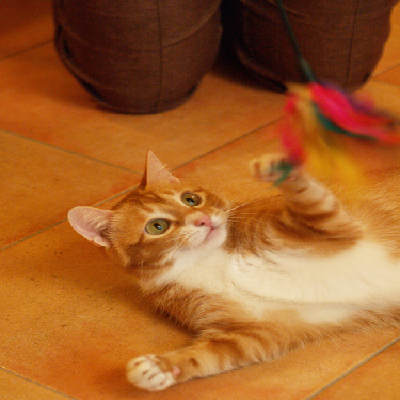

In [18]:
Image.fromarray(X[4])

In [26]:
sess.run(final_output, feed_dict={x: [X[2000]]})

array([[ 0.26091912,  0.21463673,  0.23590627,  0.28853789]], dtype=float32)

In [41]:
sess.run(final_output, feed_dict={x: [X[-6]]})

array([[ 0.25111401,  0.21590737,  0.22398373,  0.30899489]], dtype=float32)

In [70]:
class_names

['Cats', 'Dogs', 'Zebras', 'Cows']

### Dataset Preparation

In [2]:
import urllib
from tqdm import tqdm_notebook

In [11]:
def download(url_file):
    path = os.path.join(*url_file.split('/')[:-1])
    with open(url_file, 'r', encoding='utf-8') as f:
        urls = f.readlines()
        for i, url in enumerate(urls):
            try:
                urllib.request.urlretrieve(url, path+'/'+str(i)+'.jpg')
            except Exception as e:
                print(e)

In [10]:
url_files = ['Animals/Dogs/imagenet.synset.geturls?wnid=n02084071',
            'Animals/Cats/imagenet.synset.geturls?wnid=n02121808',
             'Animals/Cows/imagenet.synset.geturls?wnid=n01887787',
             'Animals/Elephants/imagenet.synset.geturls?wnid=n02503517',
             'Animals/Parrots/imagenet.synset.geturls?wnid=n10401331',
             'Animals/Zebras/imagenet.synset.geturls?wnid=n02391049', 
             'Animals/Penguins/imagenet.synset.geturls?wnid=n02055803'
            ]

In [8]:
from IPython.lib import backgroundjobs as bg

In [9]:
jobs = bg.BackgroundJobManager()

In [7]:
functions = list(map(lambda x: 'download("'+x+'")',url_files))

In [64]:
for i in functions:
    jobs.new(i)

Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.


Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
jobs.status()

In [27]:
blank_image = Image.open('flickr_blank.jpg')

In [29]:
im = Image.open('Animals/Cats/1107.jpg')

In [2]:
import urllib
import glob
from tqdm import tqdm_notebook

In [42]:
urllib.request.urlopen('http://farm1.static.flickr.com/181/453070862_e9b4239600.jpg').geturl()

'https://s.yimg.com/pw/images/en-us/photo_unavailable.png'

In [84]:
def clear_folder(folder):
    
    with open(glob.glob(os.path.join(folder, 'imagenet*'))[0], 'r', encoding='utf-8') as f:
        urls = f.readlines()
    
    for i, url in enumerate(tqdm_notebook(urls)):
        try:
            if urllib.request.urlopen(url, timeout = 3).geturl() == 'https://s.yimg.com/pw/images/en-us/photo_unavailable.png':
                os.remove(os.path.join(folder, str(i)+'.jpg'))
        except Exception as e:
            e

In [85]:
folders = list(map(lambda x: os.path.join(*x.split('/')[:-1]), url_files))

In [86]:
functions = list(map(lambda x: 'clear_folder("'+x+'")',folders))

In [87]:
for i in functions:
    jobs.new(i)

Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.
Starting job # 8 in a separate thread.


In [118]:
jobs.status()

Completed jobs:
8 : clear_folder("Animals/Dogs")
9 : clear_folder("Animals/Cats")
10 : clear_folder("Animals/Cows")
11 : clear_folder("Animals/Elephants")
12 : clear_folder("Animals/Parrots")
13 : clear_folder("Animals/Zebras")
14 : clear_folder("Animals/Penguins")
8 : clear_folder("Animals/Parrots")
8 : clear_folder("Animals/Penguins")
8 : clear_folder("Animals/Cows")
8 : clear_folder("Animals/Dogs")
8 : clear_folder("Animals/Cats")
8 : clear_folder("Animals/Cows")
8 : clear_folder("Animals/Elephants")
8 : clear_folder("Animals/Parrots")
8 : clear_folder("Animals/Zebras")
8 : clear_folder("Animals/Penguins")
8 : clear_folder("Animals/Zebras")
8 : clear_folder("Animals/Elephants")
8 : clear_folder("Animals/Dogs")
8 : clear_folder("Animals/Cats")

